# Init

In [1]:
### Basic Imports ###
import builtins, csv, datetime, os, subprocess, time, types, pprint
from time import sleep
from pprint import pprint
now = time.time

### Special Imports ###
import numpy as np
from numpy import sqrt

import py_trees
from py_trees.behaviour import Behaviour
from py_trees.common import Status
from py_trees.composites import Selector, Sequence
from py_trees.decorators import FailureIsSuccess
import py_trees.console as console

### Local Imports ###
from magpie.poses import pose_error


### Restore Vars ###
# %store -r

# Behaviors

In [2]:
########## BASE CLASS ##############################################################################

class BasicBehavior( Behaviour ):
    """ Abstract class for repetitive housekeeping """
    
    
    def __init__( self, name = None, ctrl = None ):
        """ Set name to the child class name unless otherwise specified """
        if name is None:
            super().__init__( name = str( self.__class__.__name__  ) )
        else:
            super().__init__( name = name )
        self.ctrl = ctrl
        self.logger.debug( f"[{self.name}::__init__()]" )
        if self.ctrl is None:
            self.logger.warn( f"{self.name} is NOT conntected to a robot controller!" )

        
    def setup(self):
        self.logger.debug( f"[{self.name}::setup()]" )          
        
        
    def initialise( self ):
        """ Run first time behaviour is ticked or not RUNNING.  Will be run again after SUCCESS/FAILURE. """
        self.status = Status.RUNNING # Do not let the behavior idle in INVALID
        self.logger.debug( f"[{self.name}::initialise()]" )          

        
    def terminate( self, new_status ):
        """ Log how the behavior terminated """
        self.status = new_status
        self.logger.debug( f"[{self.name}::terminate().terminate()][{self.status}->{new_status}]" )
        
        
    def update( self ):
        """ Return true in all cases """
        self.status = py_trees.common.Status.SUCCESS
        return self.status

In [3]:
########## CONSTANTS & COMPONENTS ##################################################################

### Init data structs & Keys ###
builtins._DUMMYPOSE     = np.eye(4)
builtins.MP2BB = dict()  # Hack the BB object into the built-in namespace
builtins.SCAN_POSE_KEY  = "scanPoses"
builtins.HAND_OBJ_KEY   = "handHas"
PROTO_PICK_ROT = np.array( [[ 0.0,  1.0,  0.0, ],
                            [ 1.0,  0.0,  0.0, ],
                            [ 0.0,  0.0, -1.0, ]] )

### Set important BB items ###
MP2BB[ SCAN_POSE_KEY ] = dict()



In [4]:
########## MOVEMENT BEHAVIORS ######################################################################

### Constants ###
LIBBT_TS_S       = 0.25
DEFAULT_TRAN_ERR = 0.002
DEFAULT_ORNT_ERR = 3*np.pi/180.0

In [5]:
##### Move_Q #####################################


class Move_Q( BasicBehavior ):
    """ Move the joint config `qPos` """
    
    def __init__( self, qPos, name = None, ctrl = None, rotSpeed = 1.05, rotAccel = 1.4, asynch = True ):
        """ Set the target """
        # NOTE: Asynchronous motion is closest to the Behavior Tree paradigm, Avoid blocking!
        super().__init__( name, ctrl )
        self.qPos     = qPos
        self.rotSpeed = rotSpeed
        self.rotAccel = rotAccel
        self.asynch   = asynch
    
    
    def initialise( self ):
        """ Actually Move """
        super().initialise()
        self.ctrl.moveJ( self.qPos, self.rotSpeed, self.rotAccel, self.asynch )
    
    
    def update( self ):
        """ Return SUCCESS if the target reached """
        if self.ctrl.p_moving():
            self.status = Status.RUNNING
        else:
            error = np.subtract( self.qPos, self.ctrl.get_joint_angles() )
            error = error.dot( error )
            if( error > 0.1 ):
                self.status = Status.FAILURE
            else:
                self.status = Status.SUCCESS 
        return self.status

In [6]:
##### Move_Arm ###################################
    
    
class Move_Arm( BasicBehavior ):
    """ Move linearly in task space to the designated pose """
    
    def __init__( self, pose, name = None, ctrl = None, linSpeed = 0.25, linAccel = 0.5, asynch = True ):
        """ Set the target """
        # NOTE: Asynchronous motion is closest to the Behavior Tree paradigm, Avoid blocking!
        super().__init__( name, ctrl )
        self.pose     = pose
        self.linSpeed = linSpeed
        self.linAccel = linAccel
        self.asynch   = asynch
        
        
    def initialise( self ):
        """ Actually Move """
        super().initialise()
        self.ctrl.moveL( self.pose, self.linSpeed, self.linAccel, self.asynch )
        
        
    def update( self ):
        """ Return true if the target reached """
        if self.ctrl.p_moving():
            self.status = Status.RUNNING
        else:
            pM = self.ctrl.get_tcp_pose()
            pD = self.pose
            [errT, errO] = pose_error( pM, pD )
            if (errT <= DEFAULT_TRAN_ERR) and (errO <= DEFAULT_ORNT_ERR):
                self.status = Status.SUCCESS
            else:
                print( self.name, ", POSE ERROR:", [errT, errO] )
                self.status = Status.FAILURE
        return self.status

In [7]:
##### Open_Hand ##################################
    
    
class Open_Gripper( BasicBehavior ):
    """ Open fingers to max extent """
    
    def __init__( self, name = None, ctrl = None  ):
        """ Set the target """
        super().__init__( name, ctrl )
        self.wait_s = 0.5
        
        
    def initialise( self ):
        """ Actually Move """
        super().initialise()
        self.ctrl.open_gripper()
        sleep( self.wait_s )
        
        
    def update( self ):
        """ Return true if the target reached """
        self.status = Status.SUCCESS
        return self.status
        

In [8]:
##### Set_Fingers ##################################
    
    
class Set_Gripper( BasicBehavior ):
    """ Open fingers to max extent """
    
    def __init__( self, width_m, name = None, ctrl = None  ):
        """ Set the target """
        super().__init__( name, ctrl )
        self.width_m = width_m
        self.wait_s = 0.5
        
        
    def initialise( self ):
        """ Actually Move """
        super().initialise()
        self.ctrl.set_gripper( self.width_m )
        sleep( self.wait_s )
        
    
    def update( self ):
        """ Return true if the target reached """
        self.status = Status.SUCCESS
        return self.status

In [9]:
##### Close_Hand ##################################
    
    
class Close_Gripper( BasicBehavior ):
    """ Close fingers completely """
    
    def __init__( self, name = None, ctrl = None  ):
        """ Set the target """
        super().__init__( name, ctrl )
        self.wait_s = 0.5
        
        
    def initialise( self ):
        """ Actually Move """
        super().initialise()
        self.ctrl.close_gripper()
        sleep( self.wait_s )
        
        
    def update( self ):
        """ Return true if the target reached """
        self.status = Status.SUCCESS
        return self.status

In [10]:
##### Jog_Safe ###################################

class Jog_Safe( Sequence ):
    """ Move to a target by traversing at a safe altitude """
    # NOTE: This behavior should not, on its own, assume any gripper state
    
    def __init__( self, endPose, zSAFE=0.150, name="Jog_Safe", 
                  ctrl  = None ):
        """Construct the subtree"""
        super().__init__( name = name, memory = True )
        
        # Init #
        self.zSAFE = max( zSAFE, endPose[2,3] ) # Eliminate (some) silly vertical movements
        self.ctrl  = ctrl
        
        # Poses to be Modified at Ticktime #
        self.targetP = endPose.copy()
        self.pose1up = _DUMMYPOSE.copy()
        self.pose2up = _DUMMYPOSE.copy()
        
        # Behaviors whose poses will be modified #
        self.moveUp = Move_Arm( self.pose1up, ctrl=ctrl )
        self.moveJg = Move_Arm( self.pose2up, ctrl=ctrl )
        self.mvTrgt = Move_Arm( self.targetP, ctrl=ctrl )
        
        
        # 1. Move direcly up from the starting pose
        self.add_child( self.moveUp )
        # 2. Translate to above the target
        self.add_child( self.moveJg )
        # 3. Move to the target pose
        self.add_child( self.mvTrgt )
       
        
    def initialise( self ):
        """
        ( Ticked first time ) or ( ticked not RUNNING ):
        Generate move waypoint, then move with condition
        """
        nowPose = self.ctrl.get_tcp_pose()
        
        self.pose1up = nowPose.copy()
        self.pose1up[2, 3] = self.zSAFE

        self.pose2up = self.targetP.copy()
        self.pose2up[2, 3] = self.zSAFE

        self.moveUp.pose = self.pose1up.copy()
        self.moveJg.pose = self.pose2up.copy()
        self.mvTrgt.pose = self.targetP.copy()

In [11]:
########## MANIPULATION BEHAVIORS ##################################################################


class Pick_at_Pose( Sequence ):
    """ Grasp at a target pose (Robot Frame) while traversing at a safe altitude """
    # NOTE: This behavior should not, on its own, assume any gripper state

    def __init__( self, target, zSAFE = 0.150, preGraspW_m = None, name = "Pick_at_Pose", ctrl = None ):
        """Construct the subtree"""
        super().__init__( name = name )
        self.ctrl = ctrl
        
        # 1. Open the gripper
        if preGraspW_m is None:
            self.add_child(  Open_Gripper( name = "Open", ctrl = ctrl )  )
        else:
            self.add_child(  Set_Gripper( preGraspW_m, name = "Open", ctrl = ctrl )  )
        # 2. Jog to the target
        self.add_child(  Jog_Safe( target, name = "Jog to Grasp Pose", ctrl = ctrl )  )
        # 1. Close the gripper
        self.add_child(  Close_Hand( name = "Close", ctrl = ctrl )  )

In [12]:
########## EXECUTION ###############################################################################


class HeartRate: 
    """ Sleeps for a time such that the period between calls to sleep results in a frequency not greater than the specified 'Hz' """
    # NOTE: This fulfills a purpose similar to the rospy rate
    
    def __init__( self , Hz ):
        """ Create a rate object with a Do-Not-Exceed frequency in 'Hz' """
        self.period = 1.0 / Hz; # Set the period as the inverse of the frequency , hearbeat will not exceed 'Hz' , but can be lower
        self.last = time.time()
        
    def check_elapsed( self, reset = True ):
        """ Check if the period has elapsed, Optionally `reset` the clock """
        elapsed = time.time() - self.last
        update  = elapsed >= self.period
        if( update and reset ):
            self.last = time.time()
        return update
    
    def sleep( self ):
        """ Sleep for a time so that the frequency is not exceeded """
        elapsed = time.time() - self.last
        if elapsed < self.period:
            time.sleep( self.period - elapsed )
        self.last = time.time()


""" Return a formatted timestamp string, useful for logging and debugging """
def nowTimeStamp(): return datetime.datetime.now().strftime(
    '%Y-%m-%d_%H-%M-%S')  # http://stackoverflow.com/a/5215012/893511



class StopBeetle:
    """Invasive Beetle: Kills (stops) all branches of the tree"""

    def __init__(self, killStatus):
        """Set the status that will be assigned to all branches"""
        self.status = killStatus

    def run(self, behav):
        """Kill all subtrees"""
        for chld in behav.children:
            self.run(chld)
        behav.stop(self.status)


        
def run_BT_until_done(
    rootNode,
    N              = 10000,
    tickPause      =     0.25,
    Nverb          =    50,
    breakOnFailure = True,
    breakOnSuccess = True,
    treeUpdate     = 0,
    failureTree    = 1,
    successTree    = 0,
):
    """Tick root until `maxIter` is reached while printing to terminal"""

    if Nverb:
        print(
            "About to run",
            type( rootNode ),
            "named",
            rootNode.name,
            "at",
            nowTimeStamp(),
            "with",
            1 / tickPause,
            "Hz update frequency ...",
        )

    # 0. Setup
    # rootNode.setup_subtree( childrenFirst = 0 )
    rootNode.setup_with_descendants()
    pacer = HeartRate(Hz=1 / tickPause)  # metronome

    if Nverb:
        print("Running ...\n")

    # 1. Run
    for i in range(1, N + 1):
        try:
            rootNode.tick_once()

            if Nverb > 0 and i % Nverb == 0:
                print("\n--------- Tick {0} ---------\n".format(i))
                print("Root node, Name:", rootNode.name, ", Status:", rootNode.status)
                print("\n")
                if treeUpdate:
                    print(
                        py_trees.display.unicode_tree(root=rootNode, show_status=True)
                    )

            if breakOnFailure and (rootNode.status == Status.FAILURE):
                print("Root node", rootNode.name, "failed!\n")
                if failureTree:
                    print(
                        py_trees.display.unicode_tree(root=rootNode, show_status=True)
                    )
                break
            elif breakOnSuccess and (rootNode.status == Status.SUCCESS):
                print("Root node", rootNode.name, "succeeded!\n")
                if successTree:
                    print(
                        py_trees.display.unicode_tree(root=rootNode, show_status=True)
                    )
                break
            else:
                pacer.sleep()

        except KeyboardInterrupt:
            print("\nSimulation HALTED by user at", nowTimeStamp())
            break

    print("\nRun completed! with status:", rootNode.status, "\n\n")

    insect = StopBeetle(rootNode.status)

    for i in range(3):
        rootNode.visit(insect)  # HACK required coz tree doesn't complete sometimes
        sleep(0.5)

    print("Root node", rootNode.name, "was killed by the running script!")

# Test

In [13]:
from magpie.ur5 import UR5_Interface

In [14]:
robot = UR5_Interface()
robot.start()

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 


In [15]:
b1 = Set_Gripper(0.03, name = 'set gripper', ctrl =  robot)
b2 = Open_Gripper(name = 'open gripper', ctrl = robot)

In [16]:
run_BT_until_done(b1)

About to run <class '__main__.Set_Gripper'> named set gripper at 2024-04-03_13-31-08 with 4.0 Hz update frequency ...
Running ...

Position of dxl ID: 1 set to 505 
Position of dxl ID: 2 set to 534 
Root node set gripper succeeded!


Run completed! with status: Status.SUCCESS 


Root node set gripper was killed by the running script!


In [17]:
run_BT_until_done(b2)

About to run <class '__main__.Open_Gripper'> named open gripper at 2024-04-03_13-31-10 with 4.0 Hz update frequency ...
Running ...

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
Root node open gripper succeeded!


Run completed! with status: Status.SUCCESS 


Root node open gripper was killed by the running script!


In [ ]:
from magpie import poses
# mtrx = poses.pose_vec_to_mtrx([-0.13138038, -0.59637503, 0.10047517, 2, 1, 1])

# print(mtrx)

poseA = robot.get_tcp_pose()
print(poseA)

poseB = poses.translate_pose(poseA, [0, 0, +0.2], dir_pose="self")
print(poseB)

[[ 0.99993051  0.00710841  0.00940482 -0.10754238]
 [ 0.00986928 -0.06840585 -0.99760876 -0.58571257]
 [-0.00644806  0.99763225 -0.06847125  0.2081723 ]
 [ 0.          0.          0.          1.        ]]

In [ ]:
b3 = Move_Arm(poseB, name = 'move arm', ctrl = robot, linSpeed = 0.25, linAccel = 0.5, asynch = True)

In [ ]:
run_BT_until_done(b3)

In [18]:
poseC = robot.get_joint_angles()
print(poseC)

# b4 = Move_Q(poseC, name = None, ctrl = robot, rotSpeed = 1.05, rotAccel = 1.4, asynch = True)

[ 4.70877457e+00 -1.28562719e+00 -2.33346111e+00 -2.73173839e+00
 -1.58173925e+00 -9.46823751e-04]


In [ ]:
poseC[1] += 0.3
print(poseC)

b4 = Move_Q(poseC, name = None, ctrl = robot, rotSpeed = 1.05, rotAccel = 1.4, asynch = True)

In [ ]:
run_BT_until_done(b4)

In [19]:
pose_ = robot.get_tcp_pose()
print(pose_)

[[ 0.99993111  0.00707296  0.00936785 -0.10755637]
 [ 0.00982972 -0.06836865 -0.9976117  -0.58575262]
 [-0.0064156   0.99763505 -0.06843347  0.19812892]
 [ 0.          0.          0.          1.        ]]


In [20]:
# b5 = Pick_at_Pose(pose_, zSAFE = 0.150, preGraspW_m = None, name = "Pick_at_Pose", ctrl = robot)

In [36]:
import RealSense as real
# import ObjectDetection as ob
# from magpie.ur5 import UR5_Interface
import open3d as o3d

In [37]:
def displayWorld(worldPCD):
    coordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    geometry = [coordFrame]
    geometry.append(worldPCD)
    o3d.visualization.draw_geometries(geometry)

In [38]:
urPose = robot.get_tcp_pose()
print(urPose)

urJointAngles = robot.get_joint_angles()
print(urJointAngles)

# try:
#     detector = ob.ObjectDetection(real,None,moveRelative = True)
# except Exception as e:
#     # detector.real.pipe.stop()
#     raise(e)

real = real.RealSense(0.7)
real.initConnection()

pcd,rgbdImage = real.getPCD()
depthImage,colorImage = rgbdImage.depth,rgbdImage.color
# displayWorld(pcd)
real.disconnect()

[[ 0.99993153  0.00706086  0.00933208 -0.1075694 ]
 [ 0.00979352 -0.06841685 -0.99760875 -0.58574826]
 [-0.0064055   0.99763184 -0.06848131  0.19809792]
 [ 0.          0.          0.          1.        ]]
[ 4.70873880e+00 -1.28562719e+00 -2.33348495e+00 -2.73172599e+00
 -1.58173925e+00 -9.22981893e-04]


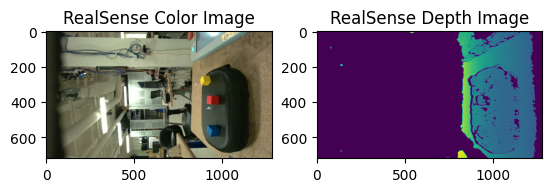

In [39]:
real.displayImages(depthImage, colorImage)

In [35]:
real.displayPCD([pcd])

In [ ]:
# robot.stop()

In [ ]:
# poseA = [[ 0.99826425,  0.04047501, -0.04278145, -0.13138038],
#          [-0.02754608, -0.32117340, -0.94661970, -0.59637503],
#          [-0.05205471,  0.94615507, -0.31950100,  0.10047517],
#          [ 0.        ,  0.        ,  0.        ,  1.        ]]

# # open_gripper( self )

# __init__( self, pose, name = None, ctrl = None, linSpeed = 0.25, linAccel = 0.5, asynch = True ):

# b1 = Move_Arm( poseA, "Move to A", ctrl = robot )

# Set_Gripper( BasicBehavior ):
    
#     def __init__( self, width_m, name = None, ctrl = None  ):

In [ ]:
# b2 = Move_Arm( poseB, "Move to B", ctrl = robot )

In [ ]:
# run_BT_until_done( b2 )

In [ ]:
# s1 = Sequence( "Jog Jog", True )
# s1.add_children([
#     Jog_Safe( poseB, zSAFE = 0.300, name = "Jog B", ctrl = robot ),
#     Jog_Safe( poseA, zSAFE = 0.300, name = "Jog A", ctrl = robot ),
# ])

In [ ]:
# run_BT_until_done( s1 )

In [ ]:
# robot.stop()

# Setup

In [ ]:
# poseA = robot.get_tcp_pose()
# %store poseA

In [ ]:
# poseB = robot.get_tcp_pose()
# %store poseB